# 数据解压显示

In [10]:
# 需要的依赖包
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from PIL import Image

## 图像显示

数据集大小为： 4200


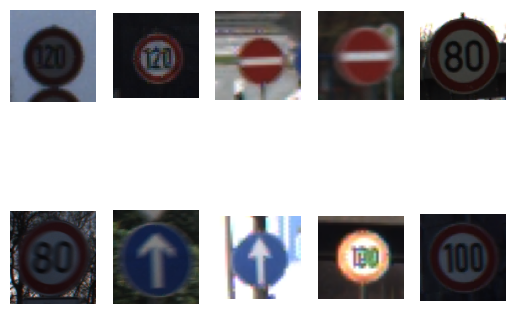

数据集大小为： 600


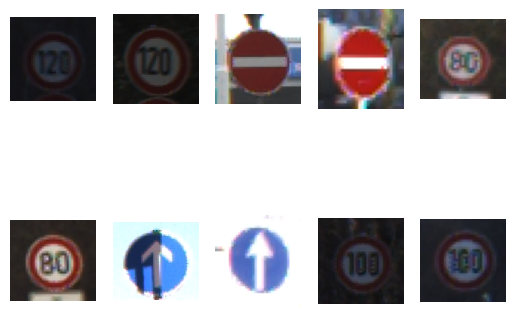

In [11]:
#定义显示图像函数
def display_image(data_dir):
	x_dir=[]
	x_filename=[]
	x_len=0
	#显示数据集大小
	for i in range(5):
		x_dir.append(os.path.join(data_dir,str(i)))
		x_filename.append(os.listdir(x_dir[i]))
		x_len=x_len+len(x_filename[i])
	print("数据集大小为：",x_len)
	#随机抽取图像存入image列表
	image=[]
	for i in range(5):
		for j in range(2):
			t=np.random.randint(0,len(x_filename[i]))
			image.append(x_dir[i]+'/'+x_filename[i][t])
	#显示image列表中的图像
	i=1
	for img_path in image:
		plt.subplot(2, 5, i)
		img=mpimg.imread(img_path)
		plt.imshow(img)
		plt.axis('Off')
		i=i+1
	plt.show()
display_image("./traffic/train/")
display_image("./traffic/validation/")



# 数据预处理

In [12]:
#对训练集做数据归一化及增强处理
TRAINING_DIR="./traffic/train/"

# 定义图像预处理和增强
def remove_alpha_channel(image):
    if image.mode == 'RGBA':
        return image.convert('RGB')
    else:
        return image
transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((150, 150)),  # 调整图像大小
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.RandomRotation(40),  # 随机旋转
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), shear=0.2, scale=(0.8, 1.2)),  # 随机仿射变换，包括平移、剪切、缩放
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1./255, 1./255, 1./255], [1, 1, 1])  # 对每个通道进行归一化，均值为1/255，标准差为1
])

# 使用ImageFolder加载数据
TRAINING_DIR = "./traffic/train/"
train_dataset = datasets.ImageFolder(TRAINING_DIR, transform=transform)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#对验证集做数据归一化处理
VALIDATION_DIR="./traffic/validation/"
# 定义验证集的图像预处理
validation_transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((150, 150)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1./255, 1./255, 1./255], [1, 1, 1])  # 对每个通道进行归一化
])

# 使用ImageFolder加载验证集数据
VALIDATION_DIR = "./traffic/validation/"
validation_dataset = datasets.ImageFolder(VALIDATION_DIR, transform=validation_transform)

# 创建验证集的数据加载器
validation_loader = DataLoader(validation_dataset,
                               batch_size=32,
                               shuffle=False)



In [13]:
# 查看训练集的标签
print(train_dataset.class_to_idx)

# 查看验证集的标签
print(validation_dataset.class_to_idx)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4}


In [14]:
class TrafficSignNet(nn.Module):

    def __init__(self):
        super(TrafficSignNet, self).__init__()
        # 第一组“卷积层+池化层+Dropout层” 输入尺寸3*150*150
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3)  # 64*148*148
        self.activation1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64*74*74
        self.dropout1 = nn.Dropout(0.3)
        # 第二组“卷积层+池化层+Dropout层”
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)  # 64*72*72
        self.activation2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 64*36*36
        self.dropout2 = nn.Dropout(0.3)
        # 第三组“卷积层+池化层+Dropout层”
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)  # 128*34*34
        self.activation3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128*17*17
        self.dropout3 = nn.Dropout(0.3)
        # 第四组“卷积层+池化层+Dropout层”
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)  # 128*15*15
        self.activation4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # 128*7*7
        self.dropout4 = nn.Dropout(0.3)
        # 拉伸层和Dropout层
        self.flatten = nn.Flatten()  # 128*7*7=6272
        self.dropout5 = nn.Dropout(0.5)
        # 全连接层和Dropout层
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.dropout6 = nn.Dropout(0.5)
        # 输出层
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.dropout1(self.pool1(self.activation1(self.conv1(x))))
        x = self.dropout2(self.pool2(self.activation2(self.conv2(x))))
        x = self.dropout3(self.pool3(self.activation3(self.conv3(x))))
        x = self.dropout4(self.pool4(self.activation4(self.conv4(x))))
        x = self.flatten(x)
        x = self.dropout5(x)
        x = F.relu(self.fc1(x))
        x = self.dropout6(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

# 创建模型实例并打印模型概要
model = TrafficSignNet()
print(model)


TrafficSignNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.3, inplace=False)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (activation2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (activation4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout4): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout5): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=6272

In [15]:

# 检查CUDA是否可用，据此设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)  # 将模型移动到指定的设备上

In [16]:
# 定义损失函数和优化器
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)

# 训练网络模型
def train_model(model, train_loader, validation_loader, epochs):
    writer = SummaryWriter('./runs/traffic_log')  # 初始化SummaryWriter
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        epoch_loss = 0.0
        with tqdm(total=len(train_loader),
                  ncols=150,
                  desc=f"epoch:{epoch+1}/{epochs}") as pBar:
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pBar.update()
                pBar.set_description(
                    f"epoch:{epoch+1}/{epochs}|running_loss:{running_loss/len(inputs)}"
                )
            epoch_loss = running_loss / len(train_loader)
            pBar.set_description(
                f"epoch:{epoch+1}/{epochs}|epch_loss:{epoch_loss}")
        writer.add_scalar('Loss/Training', epoch_loss, epoch)  # 记录训练损失
        # 验证阶段
        model.eval()
        total = 0
        correct = 0
        acc = 0.0
        best_acc = 0.0
        with torch.no_grad(), tqdm(total=len(validation_loader),
                                   ncols=150,
                                   desc=f"validate:{epoch}/{epochs}") as pBar:
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                pBar.update()
            acc = 100 * correct / total
            if acc > best_acc:
                best_acc = acc
                torch.save(model.state_dict(), "./weight/best_traffic.pth")
            pBar.set_description(f"validate:{epoch+1}/{epochs}|acc:{acc:.2f}")
        writer.add_scalar('Validation Accuracy', acc, epoch)  # 记录验证准确率

# 假设 train_loader 和 validation_loader 已经定义
train_model(model, train_loader, validation_loader, epochs=10)

# 保存模型
torch.save(model.state_dict(), "./weight/traffic.pth")

epoch:1/10|epch_loss:1.4080833214702029: 100%|██████████████████████████████████████████████████████████████████████| 132/132 [00:20<00:00,  6.54it/s]
validate:1/10|acc:63.17: 100%|████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:02<00:00,  8.56it/s]
epoch:2/10|epch_loss:1.306204875310262: 100%|███████████████████████████████████████████████████████████████████████| 132/132 [00:05<00:00, 24.41it/s]
validate:2/10|acc:62.33: 100%|████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.30it/s]
epoch:3/10|epch_loss:1.282736900177869: 100%|███████████████████████████████████████████████████████████████████████| 132/132 [00:05<00:00, 25.00it/s]
validate:3/10|acc:69.83: 100%|████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.16it/s]
epoch:4/10|epch_loss:1.2663257799365304: 100%|████████████████████████████████████████████████

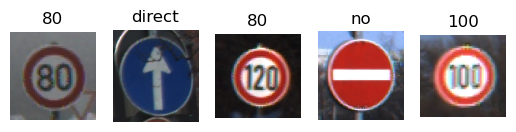

In [17]:

# 加载模型
model = TrafficSignNet()
model.load_state_dict(torch.load("./weight/best_traffic.pth"))
model = model.to(device)
model.eval()
# 读取测试集
TEST_DIR = "./traffic/test/"
test_transform = transforms.Compose([
    transforms.Lambda(remove_alpha_channel), # 去除Alpha通道
    transforms.Resize((150, 150)),  # 调整图像大小
    transforms.ToTensor(),  # 将图像转换为Tensor
    transforms.Normalize([1. / 255, 1. / 255, 1. / 255],
                         [1, 1, 1])  # 对每个通道进行归一化
])
# 对单张图像进行预测
def predict_image(model, image_path):
    image = Image.open(image_path)
    image = test_transform(image).to(device)
    image = image.unsqueeze(0)
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    return predicted.item()


label_map = {0: "120", 1: "no", 2: "80", 3: "direct", 4: "100"}
for i in range(5):
    plt.subplot(1, 5, i+1)
    image_path = f"./traffic/test/{i+1}.png"
    img=mpimg.imread(image_path)
    plt.title(label_map[predict_image(model, image_path)])
    plt.imshow(img)
    plt.axis('Off')
plt.show()